## What does this notebook do?
This notebook accesses data from [space-track.org](https://www.space-track.org/) to plot the number of rocket bodies by country and the active ones in orbit around the Earth. This data is a part of space-track's [satcat](https://www.space-track.org/documentation#api-basicSpaceDataSatcat) class ( satellite catalogue information ). For any further details, refer to the space-track's API documentation.

## Requirements:
To use this notebook, replace 'username' and 'password' with your existing login credentials. Uncomment and run the required line below to ensure necessary packages are present locally/ in the cloud.

In [1]:
# %pip install matplotlib pandas requests

In [2]:
import io
import matplotlib.pyplot as plt
import pandas as pd
import requests

In [3]:
username = None
password = None

if not username or not password:
    print("Enter valid credentials")

siteCred = { 'identity': username, 'password': password }

In [4]:
# Error class to handle 'POST' and 'GET' errors
class HandleError(Exception):
    def __init__(self, args):
        Exception.__init__(self, "Exception raised with args {0}".format(args))
        self.args = args

In [5]:
uriBase = "https://www.space-track.org"
requestLogin = "/ajaxauth/login"
requestQuery = "/basicspacedata/query"

# OBJECT_TYPE = ROCKET BODY
rocketBody = "/class/satcat/OBJECT_TYPE/ROCKET%20BODY"

# Filters data by LAUNCH
predicate1 = "/LAUNCH/%3C%3Enull"

# Orders the data by NORAD_CAT_ID
orderBy = "/orderby/NORAD_CAT_ID%20asc"

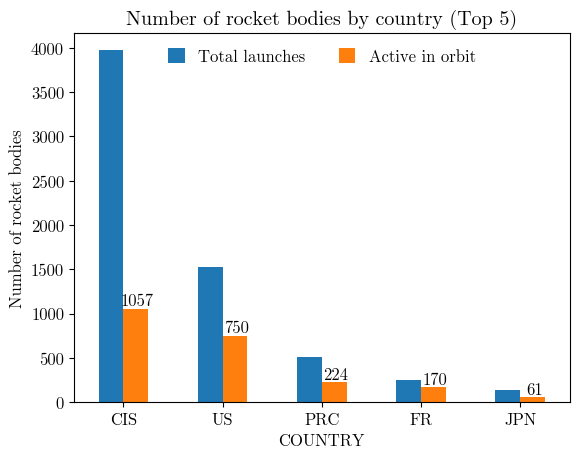

In [6]:
with requests.Session() as session:
    postCheck = session.post(uriBase + requestLogin, data = siteCred)
    if postCheck.status_code != 200:
        raise HandleError('POST')
    
    # Request for ROCKET BODY data where LAUNCH != null
    response1 = session.get(uriBase + requestQuery + rocketBody + predicate1 + orderBy)
    if response1.status_code != 200:
        raise HandleError('GET')
    
    data1 = response1.text

    dataFrame1 = pd.read_json(io.StringIO(data1))

    """
    Using any available fonts is permissible for the plots, 
    but I chose CMU Serif for aesthetic reasons.
    For Ubuntu, you can install the font package fonts-cmu 
    (using sudo apt install fonts-cmu), which contains the fonts.
    """
    # plt.rcParams['font.family'] = "CMU Serif"
    # plt.rcParams['font.size'] = 12

    resultDF = (dataFrame1.groupby(['COUNTRY', dataFrame1['DECAY'].isnull()])['COUNTRY']
              .value_counts()
              .unstack()
              .assign(Total = lambda x: x.sum(axis = 1))
              .sort_values(by = 'Total', ascending = False)
              .head(5)
              [['Total', True]])

    # Plots the number of rocket bodies by country (Top 5)
    ax = resultDF.plot.bar()

    for i, (total, active) in enumerate(zip(resultDF['Total'], resultDF[True])):
        if not pd.isnull(active):
            ax.annotate(str(int(active)), (i, active), ha = 'center', va = 'bottom', 
                        xytext = (10, 0), textcoords = "offset points")
    
    plt.xticks(rotation = 0)
    plt.xlabel('COUNTRY')
    plt.ylabel("Number of rocket bodies")
    plt.title("Number of rocket bodies by country (Top 5)")

    legendLabels = ["Total launches", "Active in orbit"]
    plt.legend(legendLabels, loc = "upper center", 
            ncols = 2,
            handlelength = 1, 
            handleheight = 1,
            frameon = False)

    plt.show()
    
session.close() 